# 簡単なベイズ実装

## Example: Inferring behaviour from text-message data


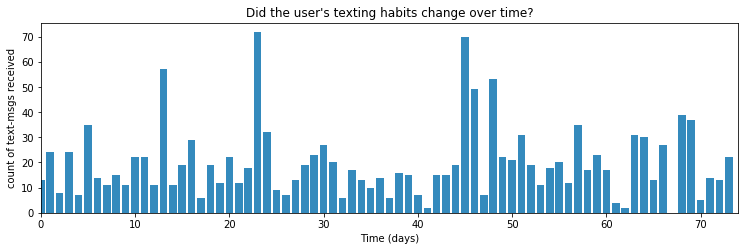

In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt

figsize(12.5, 3.5)
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

### Would you say there was a change in behaviour during this time period?

#### ①分布関数定義<br>a Poisson random variable is a very appropriate model for this type of count data. Denoting day $i$'s text-message count by $C_i$,

$$ C_i \sim \text{Poisson}(\lambda)  $$

#### ②パラメータの推定（$\lambda$)

観測期間の中である日（$\tau$日とする)においてパラメータ$\lambda$の値が突然大きくなると仮定

$$
\lambda = 
\begin{cases}
\lambda_1  &amp; \text{if } t \lt \tau \cr
\lambda_2 &amp; \text{if } t \ge \tau
\end{cases}
$$

パラメータ$\lambda$は以下の指数分布に従うとして定義<br>
指数分布の期待値は逆数になるから

$$\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}$$

$$\frac{1}{N}\sum_{i=0}^N \;C_i \approx E[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}$$



#### ③パラメータの推定（$\tau$)

一様分布とする

$$\begin{align}
& \tau \sim \text{DiscreteUniform(1,70) }\\\\
&\Rightarrow P( \tau = k ) = \frac{1}{70}
\end{align}$$

#### ④これをpythonで実装

In [2]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

In [3]:
#This code creates a new function lambda_, but really we can think of it as a random variable
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

Note that because lambda_1, lambda_2 and tau are random, lambda_ will be random.

In [4]:
#パラメータを受け渡して、ポアソン分布のオブジェクトを生成している
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [5]:
### Mysterious code to be explained in Chapter 3.
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:05<00:00, 5168.44draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [6]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


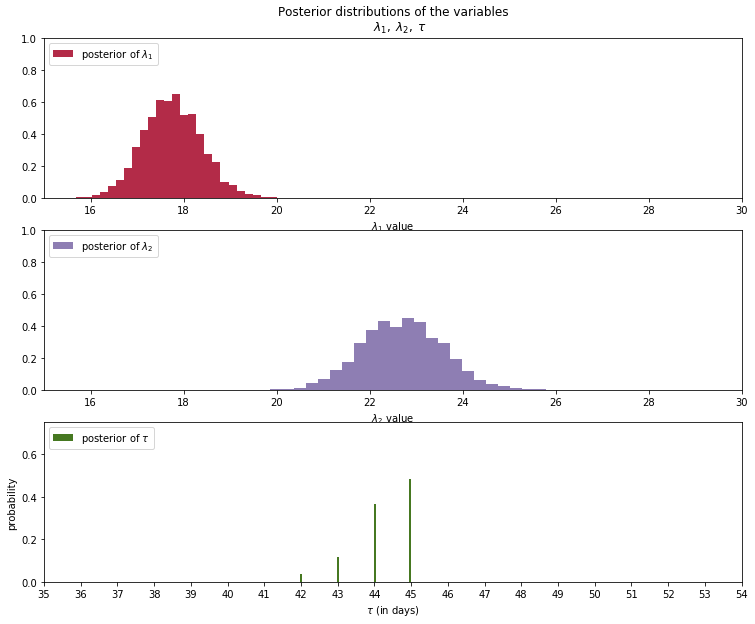

In [7]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

以上の分析により未知のパラメータの分布を得ることができた。

t日目における$\lambda$の期待値を算出

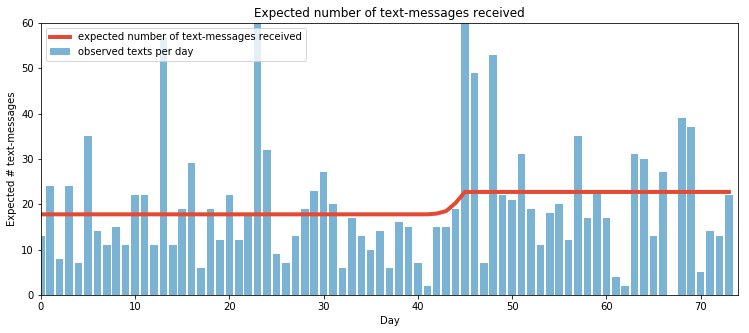

In [8]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

### Exercises¶
1. Using lambda_1_samples and lambda_2_samples, what is the mean of the posterior distributions of $\lambda_1$ and $\lambda_2$?

In [9]:
print(lambda_1_samples.mean())

17.763443478110073


In [10]:
print(lambda_2_samples.mean())

22.70604043297966


2. What is the expected percentage increase in text-message rates? hint: compute the mean of lambda_1_samples/lambda_2_samples. Note that this quantity is very different from lambda_1_samples.mean()/lambda_2_samples.mean().

In [12]:
relative_increase_samples = \
(lambda_2_samples - lambda_1_samples)/ lambda_1_samples

print(relative_increase_samples)

[0.24228583 0.24228583 0.41362453 ... 0.4160769  0.4160769  0.4160769 ]


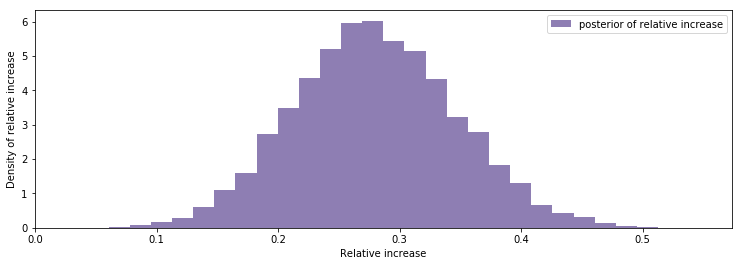

In [13]:
figsize(12.5, 4)

plt.hist(relative_increase_samples, histtype="stepfilled",
        bins=30, alpha=0.85, color="#7A68A6",normed=True,
        label="posterior of relative increase")
plt.xlabel("Relative increase")
plt.ylabel("Density of relative increase")
plt.legend()

In [14]:
print(relative_increase_samples.mean())

0.2798482990773686


3. What is the mean of $\lambda_1$ given that we know $\tau$ is less than 45. That is, suppose we have been given new information that the change in behaviour occurred prior to day 45. What is the expected value of $\lambda_1$ now? (You do not need to redo the PyMC3 part. Just consider all instances where tau_samples < 45.)

In [15]:
ix = tau_samples<45
print(lambda_1_samples[ix].mean())

17.757829901901022
